## IUM etap 2

## Skład zespołu
- Dominika Ferfecka
- Sara Fojt

## Temat projektu
Mamy innowacyjny pomysł - zacznijmy wyprzedzać naszych słuchaczy i tworzyć listę topowych utworów z tydzień przed tym zanim staną się najbardziej popularne! Przegonimy konkurencję i zwiększymy zaangażowanie użytkowników.

## Kontekst
Serwis muzyczny “Pozytywka”, pozwalający użytkownikom na odtwarzanie ulubionych utworów online. Portal pozwala użytkownikom na pomijanie aktualnie odsłuchiwanych utworów oraz na oznaczanie utworów jako polubione.

## Zadanie biznesowe
Tworzenie listy utworów, które w kolejnym tygodniu staną się najbardziej popularne w serwisie. Domyślnie wygenerowana lista będzie zawierać 50 utworów.

## Biznesowe kryterium sukcesu
Piosenki proponowane w stworzonej liście powinny utrzymać się lub stać się jednymi z najpopularniejszych utworów w serwisie w kolejnym tygodniu. Zaproponowana lista powinna zawierać co najmniej 70% takich samych piosenek, co lista rzeczywiście najpopularniejszych piosenek o tej samej liczbie utworów opublikowana w kolejnym tygodniu. Większa popularność utworów oznacza większe zaangażowanie użytkowników co przełoży się na większą ilość odsłuchanych reklam, czyli większy zysk serwisu.

## Zadanie modelowania
Modelowanie szeregów czasowych - przewidywanie popularności piosenek w serwisie w kolejnych tygodniach.

## Dane do modelowania
* dane o artystach, zawierające m.in. gatunki tworzonej przez nich muzyki
* informacje o sesjach użytkowników oraz jakie akcje wykonywali na danych utworach (pomijanie, polubienie itp.)
* informacje o utworach, zawierające liczbowe reprezentacje atrybutów takich jak energiczność, instrumentalność czy popularność (którą będziemy przewidywać)
  
Pełna analiza danych dostępna jest w poniższej sekcji “Analiza danych”.

## Analityczne kryterium sukcesu
Osiągnięcie poziomu rekomendacji:

*Popularne utwory / Zaproponowane utwory > 70%*

We wzorze powyżej "Popularne utwory" oznacza utwory znajdujące się na wygenerowanej przez nas liście utworów, która faktycznie w kolejnym tygodniu stały się popularne. Aby uznać utwór za popularny, musi znajdować się wśród 50 utworów z najwyższymi wartościami w kolumnie *popularity*.


## Założenia
* atrybut `popularity` w utworach jest zmienny w czasie
* zmiany w popularności utworów są względnie płynnie - nie uwzględniamy czynników takich jak premiery filmów, wydarzenia społeczne, które mają wpływ na popularność niektórych z utworów. Będą to dane typu MNAR (Missing Not At Random), których braku nie jesteśmy w stanie uzupełnić
* atrybuty utworów, takie jak energiczność, instrumentalność itp. które będą jednymi z danych wejściowych modelu, są stałe w czasie
* w większości użytkownicy zachowują się w sposób przewidywalny i nie zmieniają w całości swojego gustu muzycznego z tygodnia na tydzień

## Wstępne propozycje modeli
### Model bazowy
Model bazowy będzie prostym modelem opartym na krótkoterminowym przewidywaniu szeregów czasowych. Wejściem modelu będzie popularność utworu w poprzednich tygodniach, zaś wyjściem będzie przewidywana popularność w tygodniu następnym. Utwory do trenowania modelu będą grupowane według gatunków, jako że ich wykresy popularności mogą znacznie się różnić.

Wstępnie wybranym modelem jest **ARIMA (Autoregressive Integrated Moving Average)** zaimplementowany w bibliotece statsmodels w module tsa.

### Model zaawansowany
Model zaawansowany będzie implementacją neuronowej sieci rekurencyjnej (RNN) w wariancie Long Short-Term Memory (LSTM), który jest specjalnie zaprojektowany do przewidywania szeregów czasowych. Model ten pozwala nam na wprowadzenie większej ilości danych, co skutkuje uchwyceniem bardziej złożonych wzorców. Wejściem modelu, oprócz popularności w czasie, będą również stałe cechy utworów takie jak gatunek, energiczność, wykonawca, instrumentalność itd.

Wstępnie wybraną implementacją będzie model **Sequential LSTM** z biblioteki **tensorflow.keras**. Aby uniknąć nadmiernego dopasowania planowane jest również dodanie warstwy batch-normalizacji oraz dropoutu (dostępne w bibliotece), których hiperparametry będą dostosowane w testach.


# *Analiza danych*

Poniżej zostało przeprowadzana analiza danych jakie otrzymaliśmy w drugiej iteracji.


### Przygotowanie do analizy

In [1]:
!pip install pandas matplotlib

In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np


In [2]:
SESSIONS = "./V1/sessions.jsonl"
ARTISTS = "./V1/artists.jsonl"
TRACKS = "./V1/tracks.jsonl"
USERS = "./V1/users.jsonl"

## *Analiza danych o artystach (plik artists)*

In [4]:
# artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True, nrows=100))
artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))
artists_data = artists_data.dropna()
artists_data.head(20)

,id,name,genres
0,7jVv8c5Fj3E9VhNjxT4snq,Lil Nas X,"[country rap, lgbtq+ hip hop, pop rap, queer c..."
1,0xRXCcSX89eobfrshSVdyu,MEDUZA,"[dance pop, edm, pop dance, pop house, tropica..."
2,3OKg7YbOIatODzkRIbLJR4,TheFatRat,[speedrun]
3,4f7KfxeHq9BiylGmyXepGt,Tanishk Bagchi,"[desi pop, filmi, modern bollywood]"
4,56mfhUDKa1vec6rSLZV5Eg,Jawsh 685,[nz pop]
5,523y9KSneKh6APd1hKxLuF,Master KG,[south african house]
6,25UNJbwGZSQKvz5cPLWlv3,Los Dos Carnales,"[corrido, norteno, nuevo regional mexicano, re..."
7,6vTqEFbTtTRJsuIpzZgjxi,Grupo Menos É Mais,"[pagode, pagode novo]"
8,44mEtidu0VdRkIqO4IbkNa,Marca MP,"[corrido, corridos tumbados, nuevo regional me..."
9,6m6e7D2TnV0aYMllFFwMxu,Guilherme & Benuto,[sertanejo pop]


In [8]:
num_rows = artists_data.shape[0]
print(f"W pliku artists jest zawarte {num_rows} wierszy")


W pliku artists jest zawarte 1581 wierszy


### Sprawdzanie wartości null

In [7]:
null_count = artists_data.isnull().sum()
print(null_count)

id        0
name      0
genres    0
dtype: int64


Jest 86 pustych wartości w kolumnie genres

### Analiza kolumny id

In [8]:
artists_data["id"].is_unique

False

In [9]:
# wyświetlenie powtarzających się danych
value_counts = artists_data["id"].value_counts()
value_counts[value_counts > 1]


id
-1    88
Name: count, dtype: int64

Kolumna *id* zawiera 91 wartości *-1*.

### Analiza kolumny name

In [10]:
# weryfikacja znaków specjalnych

special_chars_pattern = r"[^a-zA-Z0-9\s]"

def extract_special_characters(name):
    return re.findall(special_chars_pattern, name)

artists_data["special_char_count"] = artists_data["name"].apply(lambda x: len(extract_special_characters(x)))
artists_data["special_characters"] = artists_data["name"].apply(extract_special_characters)

names_with_special_chars = artists_data[artists_data["special_char_count"] > 0]

print(names_with_special_chars[["name", "special_char_count", "special_characters"]])

artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))


                    name  special_char_count special_characters
7     Grupo Menos É Mais                   1                [É]
9     Guilherme & Benuto                   1                [&]
18     Die drei ??? Kids                   3          [?, ?, ?]
28                    優里                   2             [優, 里]
42            badmómzjay                   1                [ó]
...                  ...                 ...                ...
1592             Ben&Ben                   1                [&]
1602               Beéle                   1                [é]
1604         Joey Bada$$                   2             [$, $]
1607                Snøw                   1                [ø]
1648               Aminé                   1                [é]

[189 rows x 3 columns]


Jest 201 nazw, które zawierają znaki specjalne.

### Analiza kolumny genres

In [11]:
# zliczenie rodzajów gatunków

unique_genres = artists_data['genres'].explode().dropna().unique()
unique_genres_count = len(unique_genres)
print(f"Liczba unikalnych gatunków: {unique_genres_count}")

sample_genres = artists_data['genres'].explode().head(20)
print("\nPrzykłady gatunków:")
print(sample_genres.tolist())

# print(list(unique_genres))

Liczba unikalnych gatunków: 830

Przykłady gatunków:
['country rap', 'lgbtq+ hip hop', 'pop rap', 'queer country', 'dance pop', 'edm', 'pop dance', 'pop house', 'tropical house', 'speedrun', 'desi pop', 'filmi', 'modern bollywood', 'nz pop', 'south african house', 'corrido', 'norteno', 'nuevo regional mexicano', 'regional mexican', 'pagode']


## *Analiza danych o utworach (plik tracks)*

In [5]:
tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))
tracks_data.head(20)


,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55.0,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.3320,0.7130,88.973
1,2W889aLIKxULEefrleFBFI,None,54.0,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.3210,0.1340,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,55.0,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.1560,0.1690,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54.0,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.7880,0.5900,126.974
4,6kD1SNGPkfX9LwaGd1FG92,Put Your Dreams Away (For Another Day),53.0,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.1520,0.1000,90.150
5,5RcvlmVx2xtFcp2Ta5pw7X,Someone To Watch Over Me,57.0,196667,0,5V0MlUE1Bft0mbLlND7FJz,1950-09-11,0.354,0.0851,7,-13.738,0.0345,0.990,0.000004,0.1230,0.1970,97.684
6,None,I've Got A Crush On You,56.0,196440,0,5V0MlUE1Bft0mbLlND7FJz,1950-09-11,0.455,0.1060,2,-14.086,0.0422,0.986,0.000000,0.1220,0.2580,66.807
7,0x0ffSAP6PkdoDgHOfroof,My Funny Valentine - Remastered,54.0,150667,0,1Mxqyy3pSjf8kZZL4QVxS0,1954-01-01,0.257,0.1250,11,-14.267,0.0332,0.891,0.000000,0.1080,0.2450,84.930
8,0Hsc0sIaxOxXBZbT3ms2oj,In The Wee Small Hours Of The Morning - Remast...,60.0,180933,0,1Mxqyy3pSjf8kZZL4QVxS0,1955,0.290,0.0874,0,-16.119,0.0346,0.856,0.000957,0.1090,0.0734,114.997
9,3aEJMh1cXKEjgh52claxQp,I've Got You Under My Skin - Remastered 1998,68.0,223760,0,1Mxqyy3pSjf8kZZL4QVxS0,1956-03,0.585,0.2470,1,-12.612,0.0400,0.452,0.000009,0.1070,0.5910,127.150


In [13]:
num_rows = tracks_data.shape[0]
print(f"W pliku tracks jest zawarte {num_rows} wierszy")


W pliku tracks jest zawarte 22412 wierszy


### Sprawdzanie wartości null

In [14]:
null_count = tracks_data.isnull().sum()
print(null_count)

id                  1147
name                1136
popularity          1088
duration_ms            0
explicit               0
id_artist           1139
release_date           0
danceability           0
energy                 0
key                    0
loudness               0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
dtype: int64


Występuje dużo wartości pustych w kolumnach *id*, *name*, *popularity*, *id_artists*

### Analiza kolumny name

In [15]:
# weryfikacja znaków specjalnych

special_chars_pattern = r"[^a-zA-Z0-9\s]"

def extract_special_characters(name):
    if isinstance(name, str):
        return re.findall(special_chars_pattern, name)
    else:
        return [] 

tracks_data["special_char_count"] = tracks_data["name"].apply(lambda x: len(extract_special_characters(x)))
tracks_data["special_characters"] = tracks_data["name"].apply(extract_special_characters)

names_with_special_chars = tracks_data[tracks_data["special_char_count"] > 0]

print(names_with_special_chars[["name", "special_char_count", "special_characters"]])

tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))


                                                    name  special_char_count  \
2         Nancy (With the Laughing Face) - 78rpm Version                   3   
3      Saturday Night (Is The Loneliest Night In The ...                   2   
4                 Put Your Dreams Away (For Another Day)                   2   
6                                I've Got A Crush On You                   1   
7                        My Funny Valentine - Remastered                   1   
...                                                  ...                 ...   
22381                              Look What You've Done                   1   
22382                                Sätter Dom På Plats                   2   
22390  Up Is Down - From "Pirates of the Caribbean: A...                   6   
22392                      Immortals - From "Big Hero 6”                   3   
22411                          What They'll Say About Us                   1   

       special_characters  
2          

## Analiza kolumny id_artist
Sprawdzenie czy rekordy artystów z danym id istnieją w zbiorze danych

In [16]:
not_null_tracks_data = tracks_data[tracks_data['id_artist'].notnull()]
not_null_artists_data = artists_data[artists_data['id'].notnull()]

missing_ids_tracks_num = not_null_tracks_data[~not_null_tracks_data['id_artist'].isin(not_null_artists_data['id'])]
missing_ids_artists_num = not_null_tracks_data[~not_null_tracks_data['id_artist'].isin(not_null_artists_data['id'])]['id_artist'].unique()

missing_count_tracks_num = missing_ids_tracks_num.shape[0]
missing_count_artists_num = missing_ids_artists_num.shape[0]

print(f"Liczba utworów, których autorów nie ma w zbiorze: {missing_count_tracks_num}")
print(f"Liczba brakujących artystów, których utwory znajdują się w zbiorze: {missing_count_artists_num}")

Liczba utworów, których autorów nie ma w zbiorze: 1384
Liczba brakujących artystów, których utwory znajdują się w zbiorze: 74


### Liczba wielokrotnego wystąpienia danego utworu
Plik tracks.json zawiera wielokrotne wystąpienia danego utworu ze zmienionym atrybutem *popularity*.

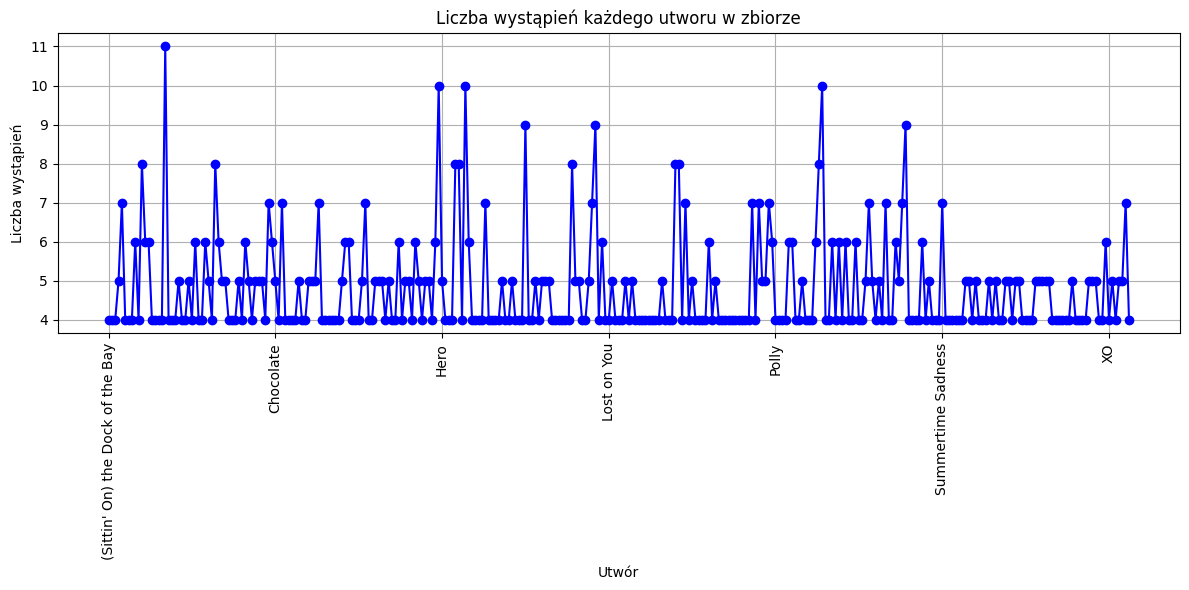

Liczba powtórzonych utworów z różnym popularity: 307
Liczba powtórzeń | Liczba utworów
4     177
5      72
6      27
7      16
8       8
10      3
9       3
11      1
Name: count, dtype: int64


In [17]:
tracks_counts = tracks_data.groupby(tracks_data["name"]).size()
filtered_tracks_counts = tracks_counts[tracks_counts > 3]
plt.figure(figsize=(12, 6))
filtered_tracks_counts.plot(kind="line", marker='o', color='b')
plt.title("Liczba wystąpień każdego utworu w zbiorze")
plt.xlabel("Utwór")
plt.ylabel("Liczba wystąpień")
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Liczba powtórzonych utworów z różnym popularity: {len(filtered_tracks_counts)}")
print(f"Liczba powtórzeń | Liczba utworów")
print(filtered_tracks_counts.value_counts())

## *Analiza danych o użytkownikach (plik users)* 

In [6]:
users_data = pd.DataFrame(pd.read_json(USERS, lines=True))
users_data = users_data.drop(columns=['id'])
users_data = users_data.dropna()
users_data.head(20)

,user_id,name,city,street,favourite_genres,premium_user
0,101,Dominik Paździora,Wrocław,aleja Jabłoniowa 55/02,"[dance pop, latin, hard rock]",0.0
1,102,Justyna Mszyca,Poznań,ul. Krótka 710,"[reggaeton, latin arena pop, modern rock]",0.0
2,103,Kornelia Witka,Gdynia,al. Kościuszki 587,"[rap, art rock, rock]",0.0
3,104,Jędrzej Kotala,Gdynia,pl. Kossaka 97/86,"[mexican pop, contemporary country, psychedeli...",0.0
4,105,Karol Kleban,Kraków,ul. Tulipanowa 861,"[rock, adult standards, permanent wave]",0.0
5,106,Julianna Kaczan,Wrocław,ul. Kołłątaja 68,"[ranchera, canadian pop, pop]",0.0
6,107,Anastazja Melcer,Kraków,plac Niecała 28,"[folk rock, dance pop, regional mexican]",0.0
8,109,Mateusz Czulak,Radom,ul. Azaliowa 60/54,"[electropop, latin arena pop, latin]",1.0
9,110,Szymon Luberda,Kraków,aleja Wiśniowa 25/31,"[rock, reggaeton, hard rock]",1.0
10,111,Norbert Tofil,Kraków,al. Niepodległości 85,"[country, adult standards, ranchera]",0.0


### Analiza kolumny ulubionych gatunków

In [19]:
unique_genres = users_data['favourite_genres'].explode().dropna().unique()
unique_genres_count = len(unique_genres)
print(f"Liczba unikalnych gatunków: {unique_genres_count}")

sample_genres = users_data['favourite_genres'].explode().head(30)
print("\nPrzykłady gatunków:")
print(sample_genres.tolist())

Liczba unikalnych gatunków: 50

Przykłady gatunków:
['dance pop', 'latin', 'hard rock', 'reggaeton', 'latin arena pop', 'modern rock', 'rap', 'art rock', 'rock', 'mexican pop', 'contemporary country', 'psychedelic rock', 'rock', 'adult standards', 'permanent wave', 'ranchera', 'canadian pop', 'pop', 'folk rock', 'dance pop', 'regional mexican', 'electropop', 'latin arena pop', 'latin', 'rock', 'reggaeton', 'hard rock', 'country', 'adult standards', 'ranchera']


favourite_genres
modern rock             70
hip hop                 70
country                 69
latin pop               64
pop rap                 62
pop                     61
rap                     61
latin arena pop         60
canadian pop            60
corrido                 58
uk pop                  58
alternative rock        58
norteno                 58
ranchera                58
country road            57
k-pop boy group         57
dance pop               57
reggaeton               57
trap latino             56
k-pop                   56
rock en espanol         56
hard rock               56
nu metal                56
alternative metal       55
permanent wave          55
rock                    54
r&b                     54
adult standards         54
mexican pop             54
neo mellow              54
latin                   53
french hip hop          52
urban contemporary      52
pop rock                52
psychedelic rock        51
post-grunge             50
album rock 

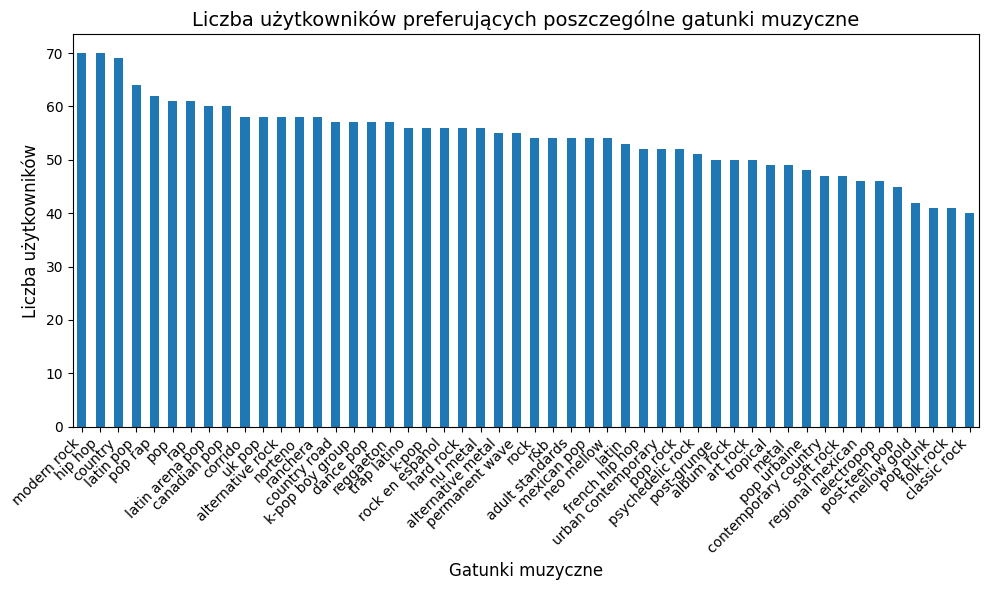

In [20]:
genres_data = users_data.explode('favourite_genres')
genres_count = genres_data['favourite_genres'].value_counts()

print(genres_count)

plt.figure(figsize=(10, 6))
genres_count.plot(kind='bar')
plt.title('Liczba użytkowników preferujących poszczególne gatunki muzyczne', fontsize=14)
plt.xlabel('Gatunki muzyczne', fontsize=12)
plt.ylabel('Liczba użytkowników', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Rozkład kluczowych atrybutów

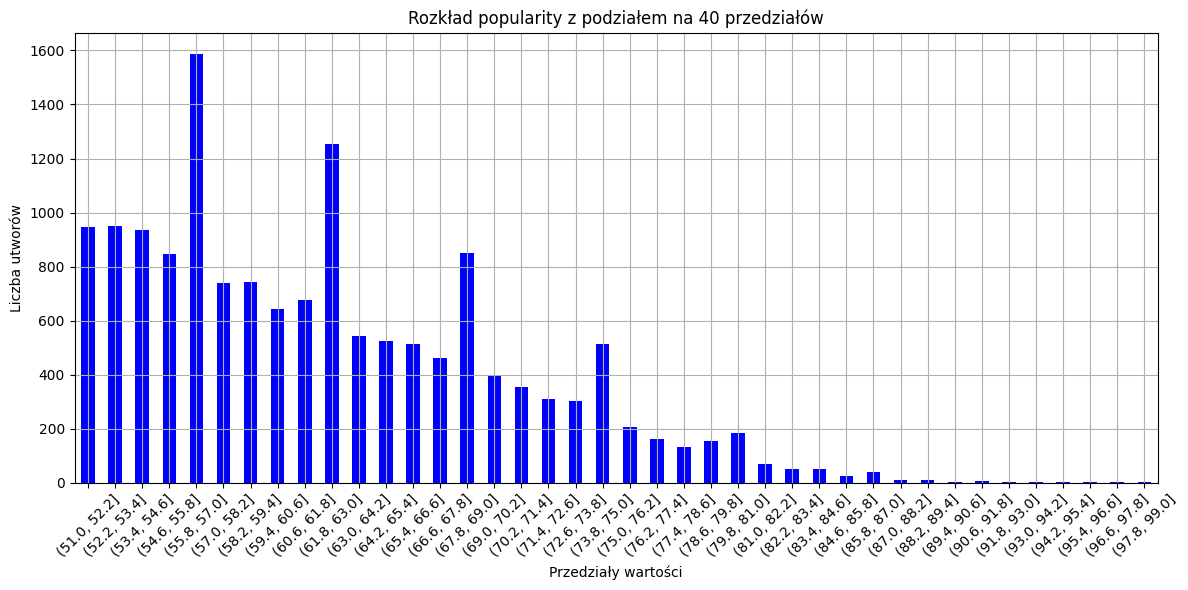

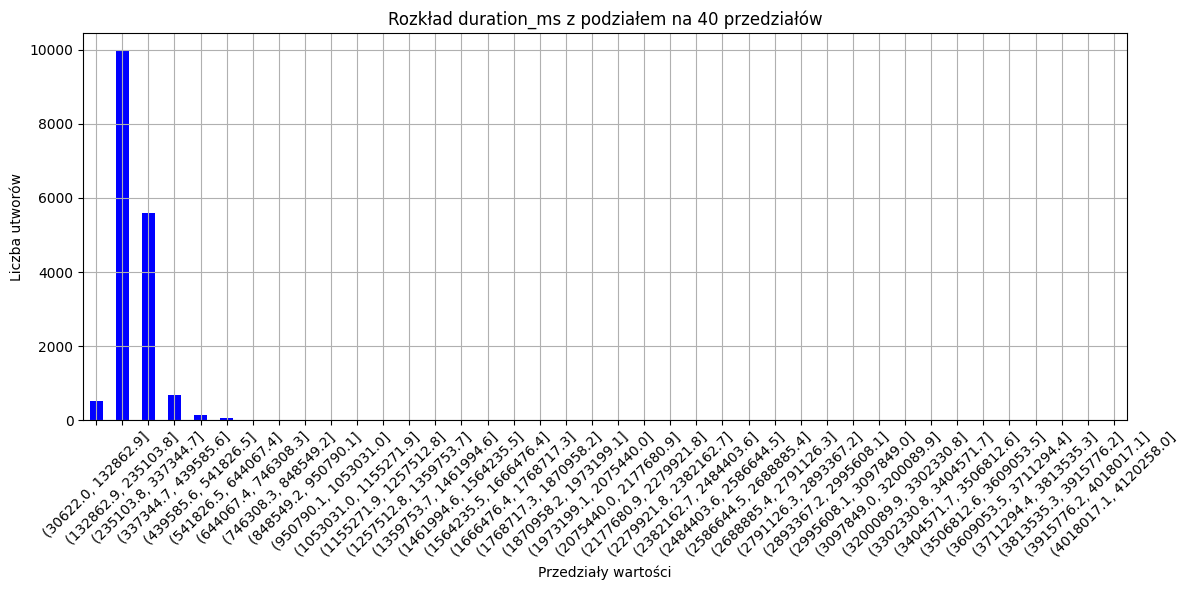

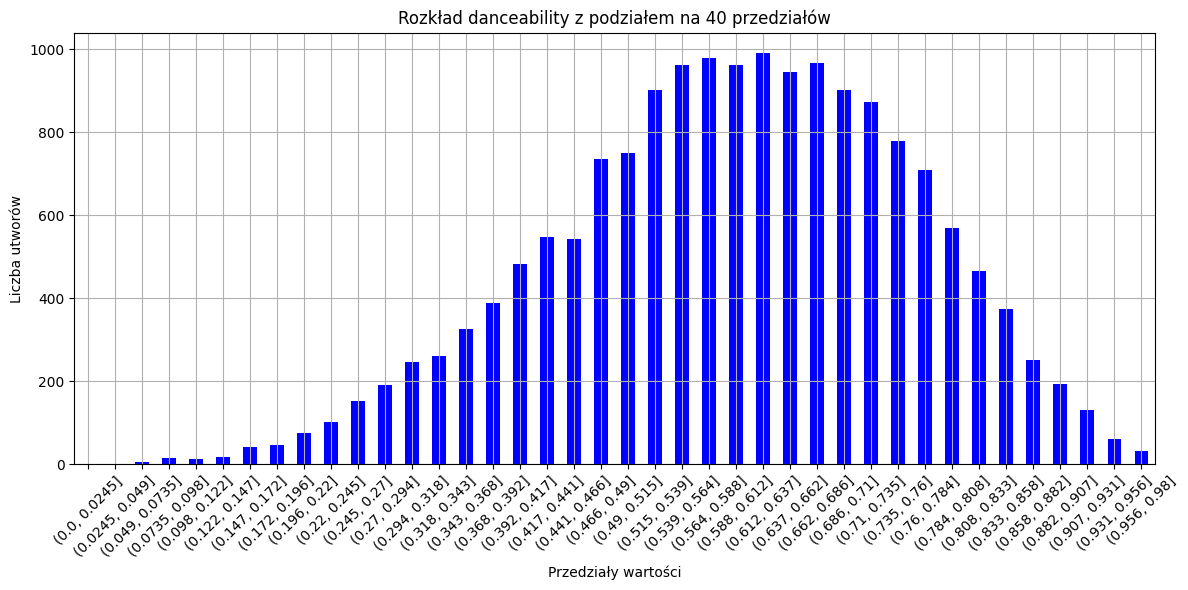

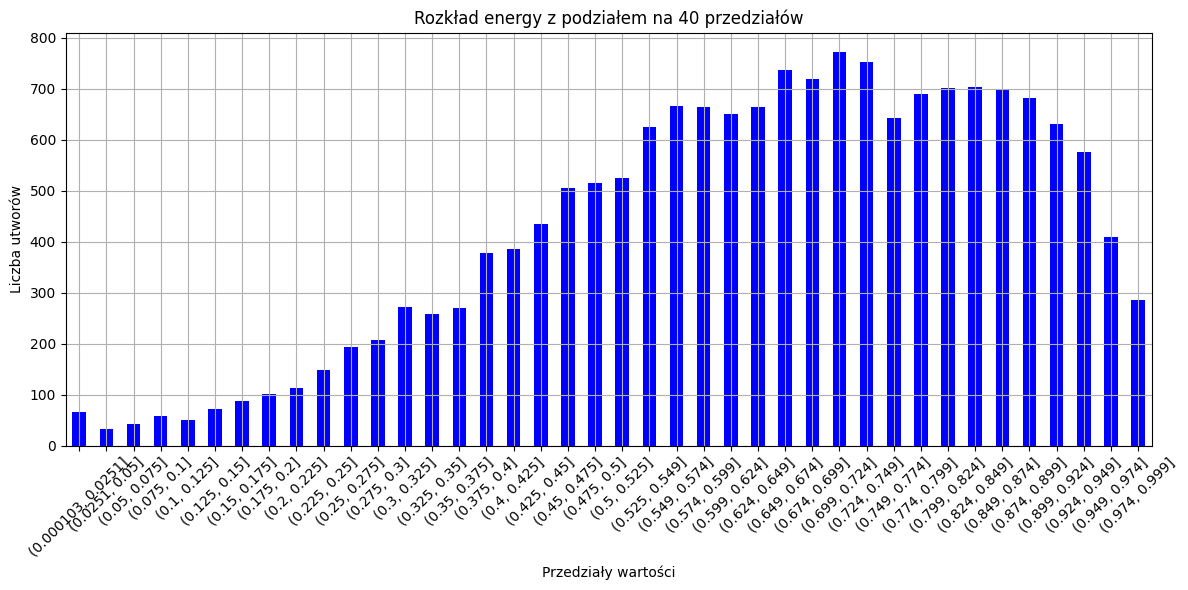

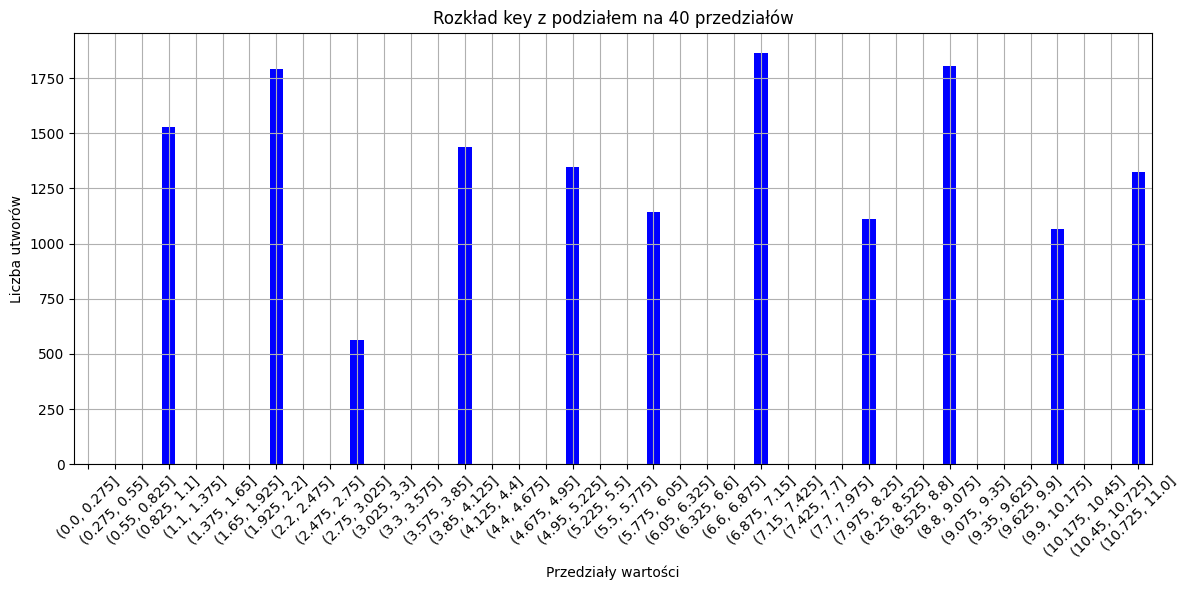

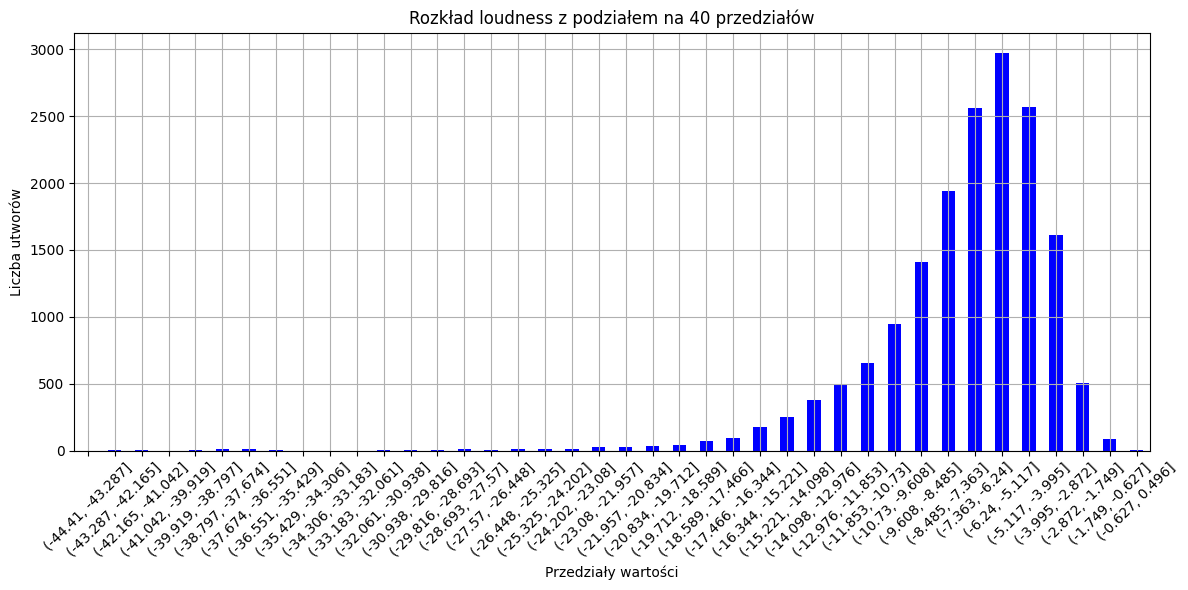

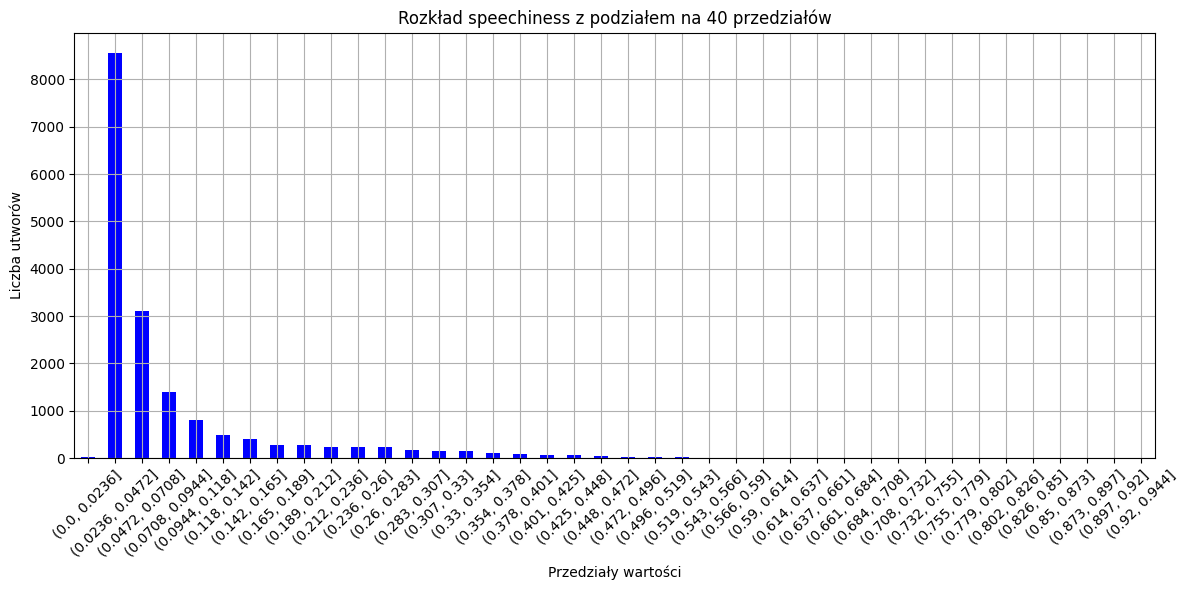

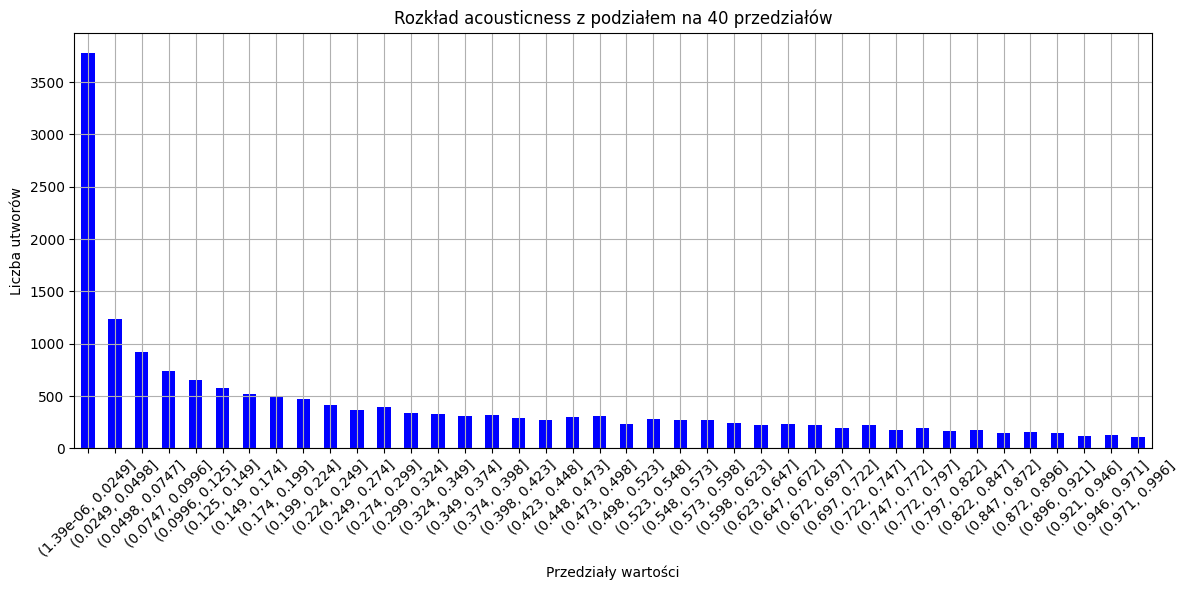

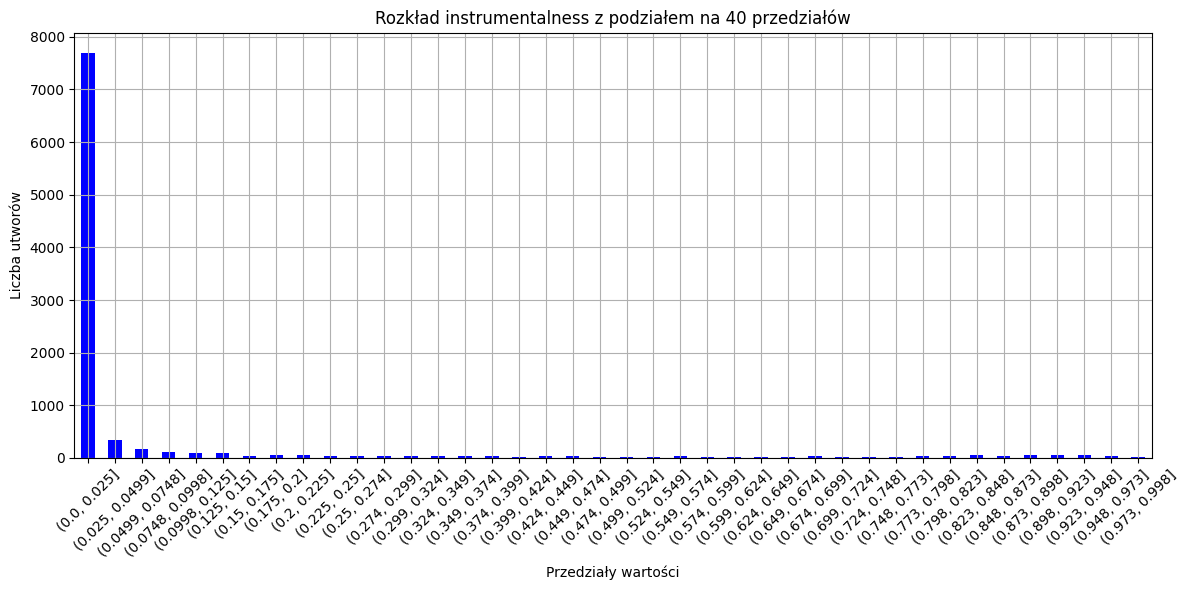

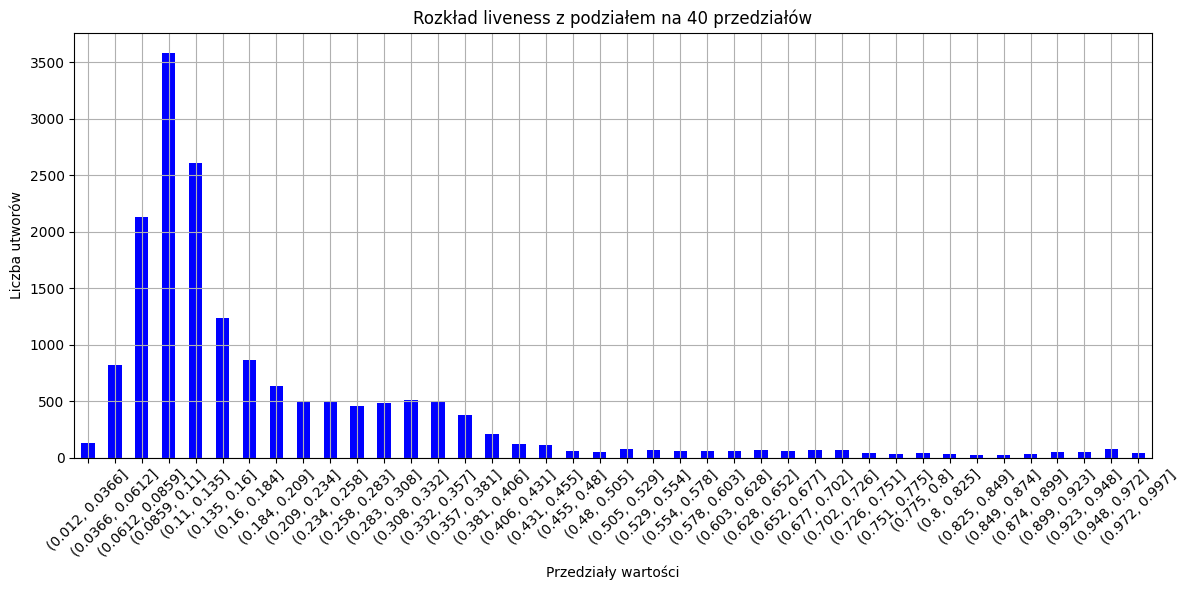

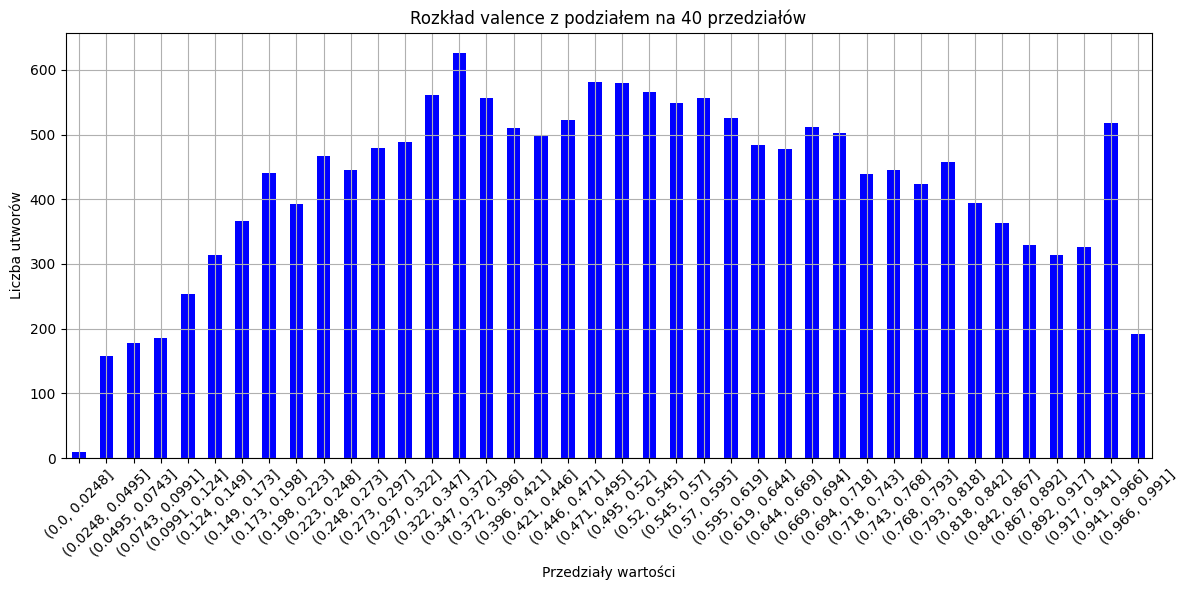

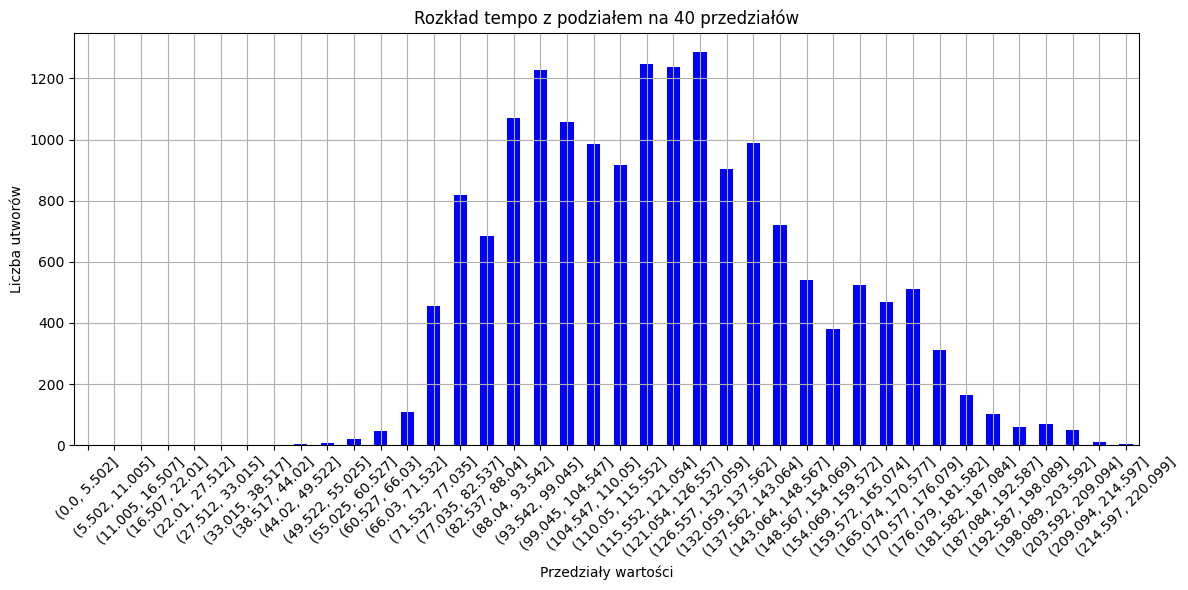

In [21]:
unique_tracks_data = tracks_data.drop_duplicates(subset="name")
unique_tracks_data = unique_tracks_data.copy()
params = ["popularity", "duration_ms", "danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]


for param in params:
    bins = np.linspace(unique_tracks_data[param].min(), unique_tracks_data[param].max(), 41)

    unique_tracks_data['bin'] = pd.cut(unique_tracks_data[param], bins)
    bin_counts = unique_tracks_data['bin'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    bin_counts.plot(kind='bar', color='blue')

    plt.title(f'Rozkład {param} z podziałem na 40 przedziałów')
    plt.xlabel('Przedziały wartości')
    plt.ylabel('Liczba utworów')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

## *Analiza danych o sesjach użytkowników (plik sessions)*

In [7]:
sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True))
# sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True, nrows=5000))
sessions_data = sessions_data.dropna()
sessions_data.head(20)

,session_id,timestamp,user_id,track_id,event_type
0,124,2024-02-28 01:30:18.593281,101.0,4rmIfFUZhhi9sS5IYtpkXw,play
3,124,2024-02-28 01:37:10.595281,101.0,5iItYl3Q6wCnKVfpK1uNVf,play
4,124,2024-02-28 01:41:41.678281,101.0,5iItYl3Q6wCnKVfpK1uNVf,like
7,124,2024-02-28 01:43:30.494281,101.0,7ygpwy2qP3NbrxVkHvUhXY,skip
8,124,2024-02-28 01:43:35.494281,101.0,30uLviIQ59DMggZOC2VNpo,play
9,124,2024-02-28 01:46:36.987281,101.0,3pGBIgFdfdnjtHDJR4nbrR,play
10,124,2024-02-28 01:48:38.376281,101.0,3pGBIgFdfdnjtHDJR4nbrR,like
11,124,2024-02-28 01:51:54.120281,101.0,3dubLey4QOmUjJCyiGPEMo,play
13,124,2024-02-28 01:53:03.331281,101.0,3dubLey4QOmUjJCyiGPEMo,like
14,124,2024-02-28 01:55:40.547281,101.0,4ha9ajL4Kz98uldAfuos6p,play


In [23]:
num_rows = sessions_data.shape[0]
print(f"W pliku sessions jest zawarte {num_rows} wierszy")


W pliku sessions jest zawarte 3591 wierszy


### Sprawdzanie wartości null

In [24]:
null_count = sessions_data.isnull().sum()
print(null_count)

session_id    0
timestamp     0
user_id       0
track_id      0
event_type    0
dtype: int64


W kolumnach takich jak *track_id*, *event_type*, *user_id* występują wartości null

### Zliczenie użytkowników

In [25]:
unique_users_count = sessions_data["user_id"].nunique()
print(f"Ilość użytkowników: {unique_users_count}")

Ilość użytkowników: 3


### Częstotliwość danych

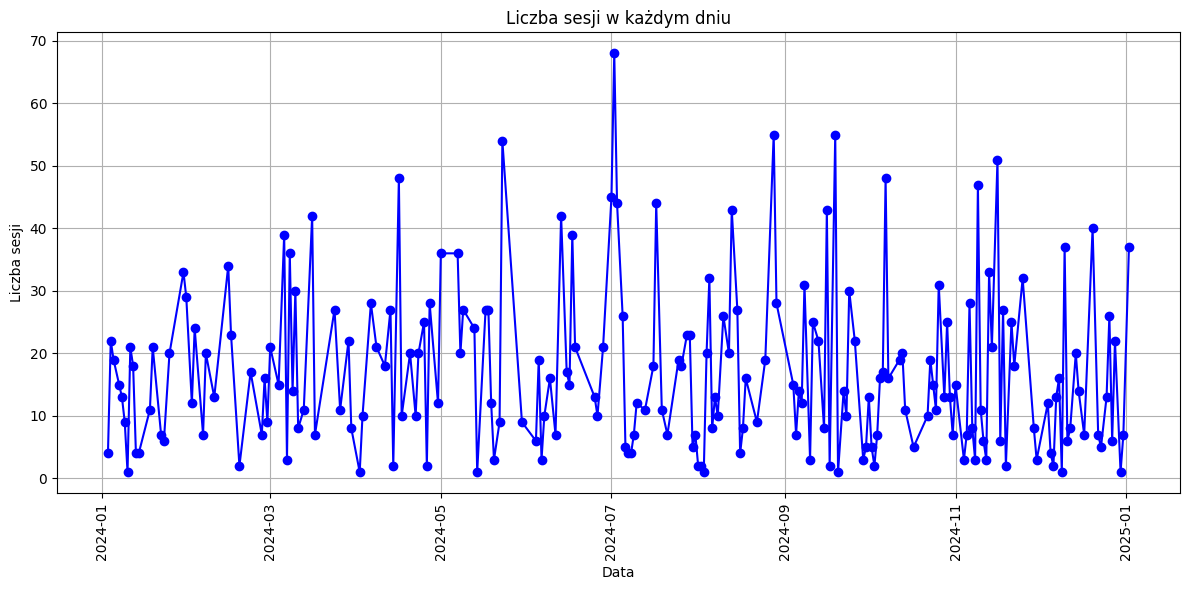

In [26]:
sessions_data["timestamp"] = pd.to_datetime(sessions_data["timestamp"])
sessions_per_day = sessions_data.groupby(sessions_data["timestamp"].dt.date).size()

plt.figure(figsize=(12, 6))
sessions_per_day.plot(kind="line", marker='o', color='b')

plt.title("Liczba sesji w każdym dniu")
plt.xlabel("Data")
plt.ylabel("Liczba sesji")
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()

### Rozkład sesji dla użytkowników

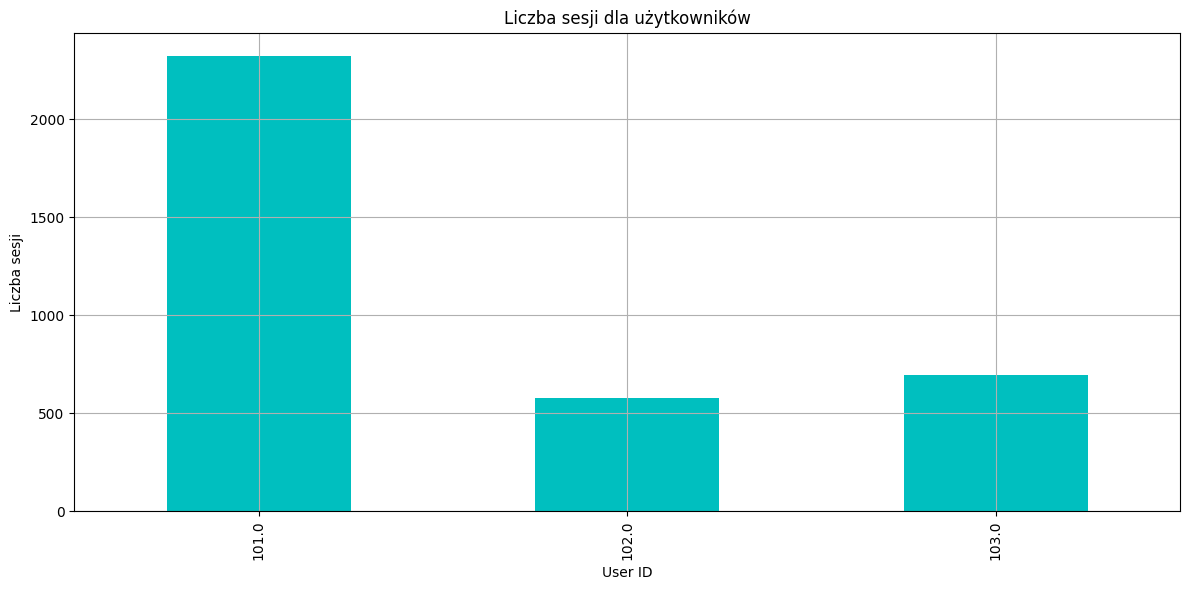

In [27]:
sessions_per_user = sessions_data.groupby("user_id").size()

plt.figure(figsize=(12, 6))
sessions_per_user.plot(kind="bar", color='c')

plt.title("Liczba sesji dla użytkowników")
plt.xlabel("User ID")
plt.ylabel("Liczba sesji")
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()


### Analiza kolumny track_id
Sprawdzenie powiązania dostępnych danych na podstawie kolumny track_id

In [28]:
not_null_tracks_data = tracks_data[tracks_data['id'].notnull()]
not_null_sessions_data = sessions_data[sessions_data['track_id'].notnull()]

missing_ids_sessions_num = not_null_sessions_data[~not_null_sessions_data['track_id'].isin(not_null_tracks_data['id'])]['track_id']
missing_ids_tracks_num = not_null_sessions_data[~not_null_sessions_data['track_id'].isin(not_null_tracks_data['id'])]['track_id'].unique()

missing_count_sessions_num = missing_ids_sessions_num.shape[0]
missing_count_tracks_num = missing_ids_tracks_num.shape[0]

print(f"Liczba odtworzeń, których utworów nie ma w zbiorze: {missing_count_sessions_num}")
print(f"Liczba brakujących utworów, których odtworzenia znajdują się w zbiorze: {missing_count_artists_num}")

Liczba odtworzeń, których utworów nie ma w zbiorze: 196
Liczba brakujących utworów, których odtworzenia znajdują się w zbiorze: 74


# Analiza atrybutów

## Potrzebne zbiory danych i atrybuty
- Dane utworów (tracks):
    - id - identyfikacja utworów
    - name - nazwa utworu będzie wykorzystywana do czytelnego tworzenia playlist
    - popularity - aktualna i historyczna popularność będzie wykorzystywana jako wartość bazowa do obliczenia przewidywanej popularity
    - id_artist - identyfikacja kto jest autorem utworu
    - release_date - data publikacji może wpływać na popularność, data zostanie ograniczona tylko do roku publikacji
    - duration_ms - czas utworu może wpływać na popularność
    - explicit, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo - cechy utworów, które mogą wpływać na popularność:
- Dane artystów (artists):
    - name - nazwisko artysty będzie wykorzystywane do czytelnego tworzenia playlist
    - genres - gatunki w których tworzą artyści może wpływać na popularność utworu
- Dane sesji (sessions):
    - event_type - liczba play/like/skip będzie wpływać na popularność
    - timestamp - wykorzystywana do sprecyzowania kiedy następowały dane akcje związane z utworem

- Dane użytkowników (brakujące) - do sprawdzenia reprezentytawności danych


## Planowane zmienne wejściowe modelu
- Dane utworów (tracks):
    - id
    - popularity
    - duration_ms
    - release_year
    - danceability
    - energy
    - loudness
    - speechiness
    - acousticness
    - instrumentalness
    - liveness
    - valence
    - tempo
- Dane sesji (sessions):
    - play_count
    - like_count
    - skip_count
    - timestamp 


## Planowane zmienne wyjściowe modelu
- popularity_score - przewidywana popularność na przyszły tydzień, na podstawie jej będą tworzone utwory z najbardziej popularnymi w przyszłym tygodniu utworami

## Korelacja popularności z cechami utworów

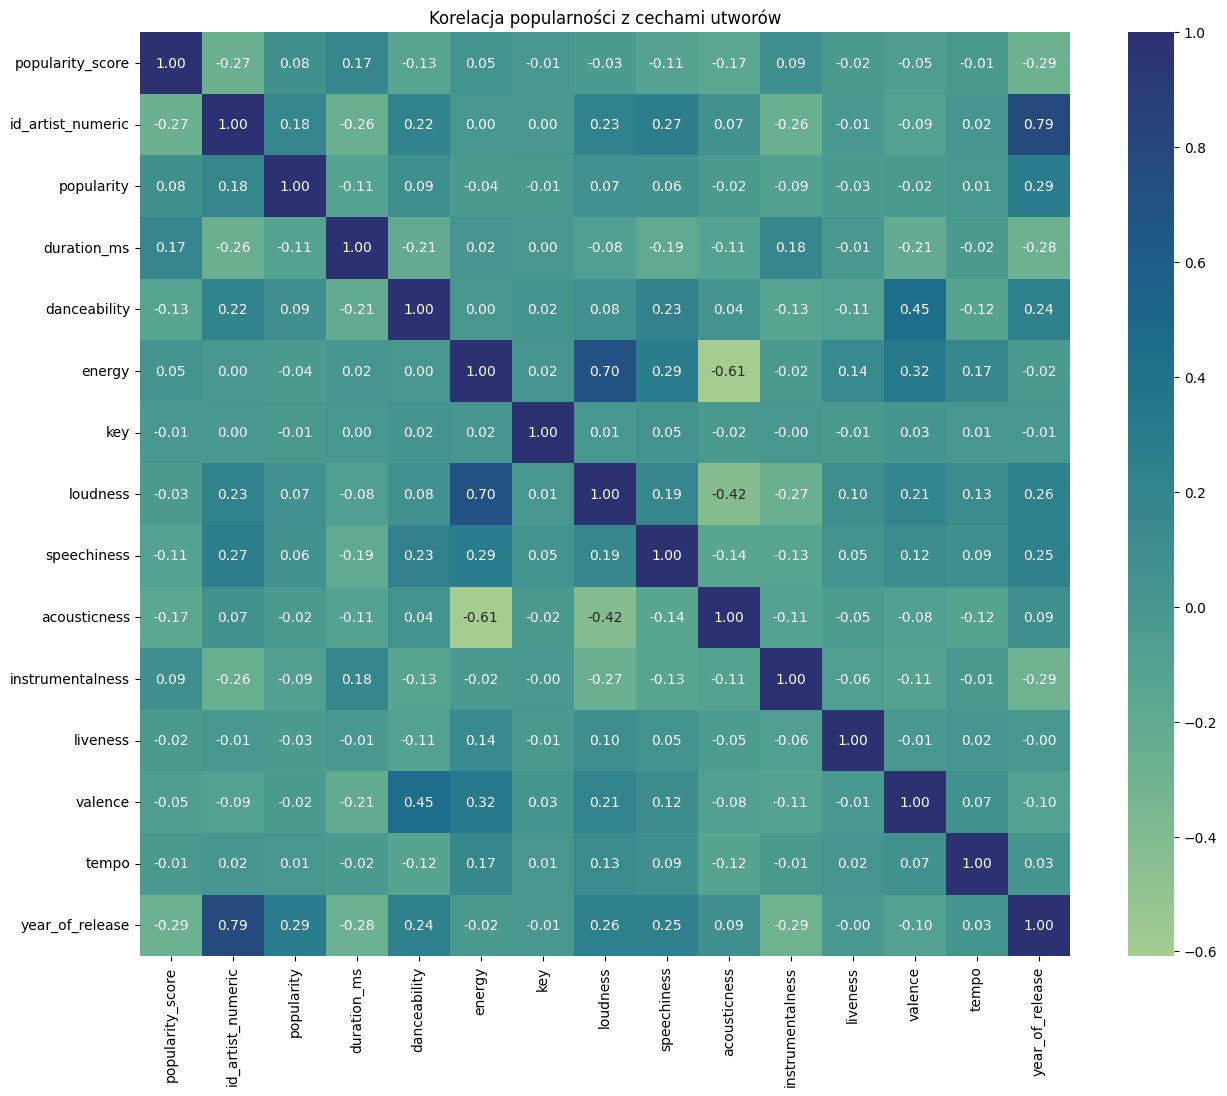

In [13]:
relevant_events = sessions_data[sessions_data['event_type'].isin(['play', 'skip', 'like'])]

event_counts = relevant_events.groupby(['track_id', 'event_type']).size().unstack(fill_value=0)

event_counts = event_counts.rename(columns={
    'play': 'play_count',
    'skip': 'skip_count',
    'like': 'like_count'
})

tracks_with_counts = tracks_data.merge(event_counts, how='left', left_on='id', right_index=True)

tracks_with_counts[['play_count', 'skip_count', 'like_count']] = tracks_with_counts[['play_count', 'skip_count', 'like_count']].fillna(0)

w1, w2, w3 = 1.0, 0.8, 0.5  # Wagi
tracks_with_counts['popularity_score'] = (
    w1 * tracks_with_counts['play_count'] +
    w2 * tracks_with_counts['like_count'] -
    w3 * tracks_with_counts['skip_count']
)

tracks_with_counts['id_artist_numeric'] = tracks_with_counts['id_artist'].factorize()[0]
tracks_with_counts = tracks_with_counts.drop(columns=['play_count', 'skip_count', 'like_count'])


tracks_data_for_popularity_new = tracks_with_counts.drop(columns=["name", "id", "id_artist", "release_date", "explicit"])
tracks_data_for_popularity_new["year_of_release"] = tracks_with_counts["release_date"].str[:4].astype(int)

moved = ["popularity_score", "id_artist_numeric"]
rest_columns = [col for col in tracks_data_for_popularity_new.columns if col not in moved]
tracks_data_for_popularity_new = tracks_data_for_popularity_new[moved + rest_columns]

spearman_corr_matrix = tracks_data_for_popularity_new.corr(method="spearman")

plt.figure(figsize=(15, 12))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="crest", fmt=".2f")
plt.title("Korelacja popularności z cechami utworów")
plt.show()


## Korelacja popularności utworów z sesjami użytkowników

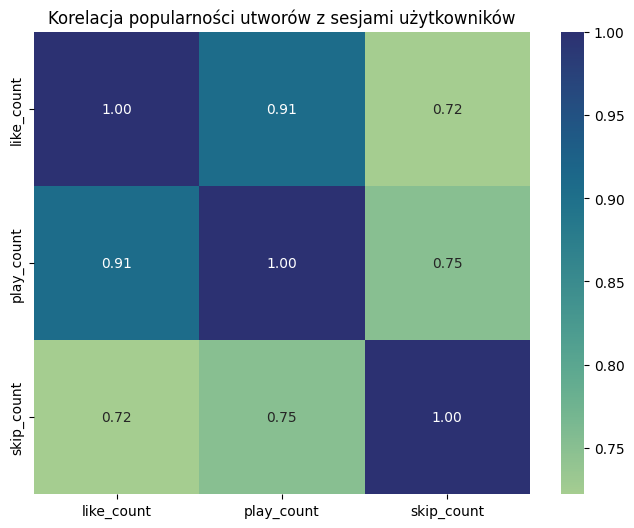

In [ ]:
sessions_data = sessions_data[
    sessions_data["event_type"].notnull() & (sessions_data["event_type"] != "advertisment")
]

session_events = (
    sessions_data.groupby(["track_id", "event_type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

session_events.columns = ["track_id", "like_count", "play_count", "skip_count"]
selected_data = session_events[["like_count", "play_count", "skip_count"]]
popularity_corr = selected_data.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(popularity_corr, annot=True, cmap="crest", fmt=".2f")
plt.title("Korelacja popularności utworów z sesjami użytkowników")
plt.show()

In [11]:
!pip install scikit-learn

## Współczynniki informacji wzajemnej między gatunkami artystów a popularity_score

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import mutual_info_regression

merged_df = pd.merge(tracks_with_counts, artists_data[['id', 'genres']], left_on='id_artist', right_on='id', how='left')
merged_df['genres'] = merged_df['genres'].apply(lambda x: x if isinstance(x, list) else [])

genres = merged_df['genres'].apply(set) 
mlb = MultiLabelBinarizer()  # tworzenie macierzy cech binarnych dla gatunków
genres_encoded = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=genres.index)

# obliczenie Mutual Information Scores dla popularity_score
mi_scores = mutual_info_regression(genres_encoded, merged_df['popularity_score'])


mi_scores_sorted = sorted(zip(genres_encoded.columns, mi_scores), key=lambda x: x[1], reverse=True)

print("Top 100 Mutual Information Scores (gatunki vs popularity_score):")
for feature, score in mi_scores_sorted[:100]:
    print(f"{feature}: {score}")

## Współczynniki informacji wzajemnej między ulubionymi gatunkami użytkowników a popularity_score

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

sessions_with_users = pd.merge(sessions_data, users_data[['user_id', 'favourite_genres']], on='user_id', how='inner')

sessions_with_tracks = pd.merge(sessions_with_users, tracks_with_counts[['id', 'popularity_score']], 
                                left_on='track_id', right_on='id', how='inner')

sessions_with_tracks['favourite_genres'] = sessions_with_tracks['favourite_genres'].apply(
    lambda x: x if isinstance(x, list) else []
)

mlb = MultiLabelBinarizer()
favourite_genres_encoded = pd.DataFrame(
    mlb.fit_transform(sessions_with_tracks['favourite_genres']), 
    columns=mlb.classes_, 
    index=sessions_with_tracks.index
)

mi_scores = mutual_info_regression(favourite_genres_encoded, sessions_with_tracks['popularity_score'])

mi_scores_sorted = sorted(zip(favourite_genres_encoded.columns, mi_scores), key=lambda x: x[1], reverse=True)

print("Mutual Information Scores (ulubione gatunki vs popularity_score):")
for feature, score in mi_scores_sorted:
    print(f"{feature}: {score}")


: 

## Analiza średniej popularności utworów artystów

/tmp/ipykernel_8474/4280130979.py:13: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


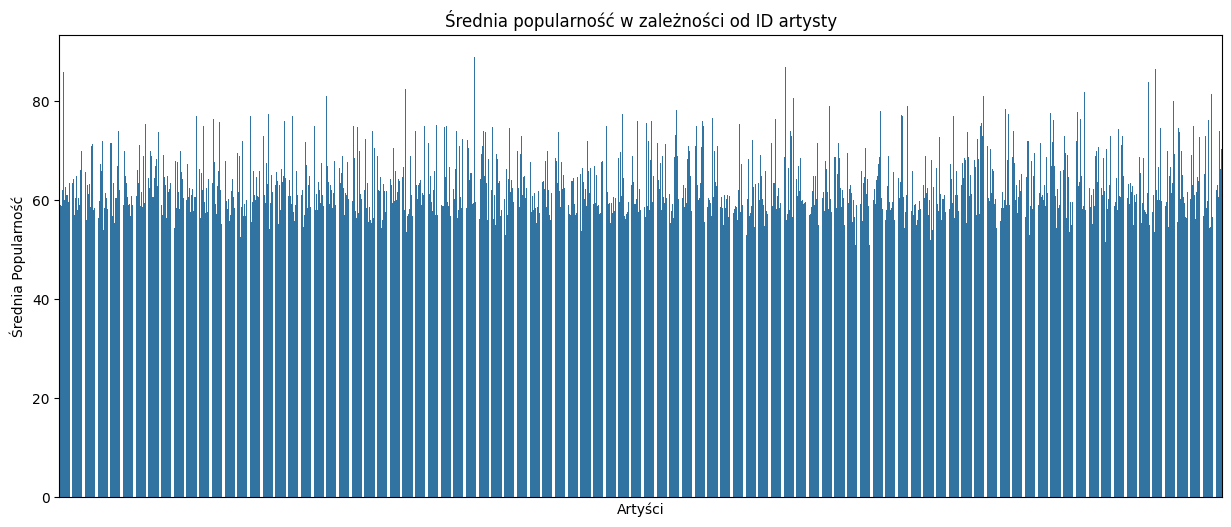

In [33]:
df_tracks_with_artists = pd.merge(tracks_data, artists_data,left_on="id_artist", right_on="id", how="left")
df_tracks_with_artists = df_tracks_with_artists.dropna()
df_for_corr = df_tracks_with_artists[["id_x", "name_x", "popularity","id_artist", "id_y", "name_y"]]

df_artists_popularity = df_tracks_with_artists[['id_artist', 'popularity']]
df_artists_popularity = df_artists_popularity.groupby('id_artist')['popularity'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(x='id_artist', y='popularity', data=df_artists_popularity)
plt.title("Średnia popularność w zależności od ID artysty")
plt.xlabel("Artyści")
plt.ylabel("Średnia Popularność")
plt.xticks([])
plt.show()

# Szczegółowy plan modelów (jakie dane wejściowe, jakie wyjściowe)

## Model naiwny (ARIMA)

Działa tylko na podstawie danych historycznych.

Wejście:
- wartość popularity_score w poprzednich tygodniach

Wyjście:
- przewidywane popularity_score w następnym tygodniu na podstawie, którego zostanie wybrana lista najpopularniejszych utworów.


## Model zaawansowany 

Model zaawansowany będzie implementacją neuronowej sieci rekurencyjnej (RNN) w wariancie Long Short-Term Memory (LSTM). Zaimplementowany będzie za pomocą modelu Sequential LSTM z biblioteki tensorflow.keras.

Wejście:
- wartość popularity_score w poprzednich tygodniach
- id artysty (id_artist_numeric) - (korelacja: 0.27)
- duration_ms - (korelacja: 0.17)
- danceability - (korelacja: 0.13)
- energy - (korelacja: 0.05)
- loudness - (korelacja: 0.06)
- speechiness - (korelacja: 0.11)
- acousticness - (korelacja: 0.17)
- popularity (korelacja: 0.08)
- instrumentalness - (korelacja: 0.09)
- year_of_release - (korelacja: 0.29)
- ulubione utwory użytkowników

Wyjście:
- przewidywane popularity_score w następnym tygodniu na podstawie, którego zostanie wybrana lista najpopularniejszych utworów.
